In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


**Problem 1**: Use the covariance matching technique to find the correct match in the color image
given on the WWW site (target.jpg). The model covariance matrix (of <x,y,R,G,B>
features) is given below (notice x,y vs. row,col!).
modelCovMatrix = [47.917 0 ‐146.636 ‐141.572 ‐123.269;
0 408.250 68.487 69.828 53.479;
‐146.636 68.487 2654.285 2621.672 2440.381;
‐141.572 69.828 2621.672 2597.818 2435.368;
‐123.269 53.479 2440.381 2435.368 2404.923];
Test all possible 1-pixel overlapping windows (each of size 70 rows by 24 columns,
with the upperleft-corner as the window origin) in the image with the given model.
Save the match distance for each box location in the image at each pixel location (for
the origin of the window). Plot/display the match-distance-image. Provide the
location of the best match distance for the best candidate. Note that the above given
covariance matrix is biased (normalized with 1/(M*N)), and Matlab’s cov function is
unbiased by default using 1/(M*N-1), so call cov( X, 1 ) to make it consistent
(biased). Leave the image with colors ranging 0-255 (do not scale/normalize the
colors). NOTE: make sure not to take a log() of zero at any time! [5 pts]

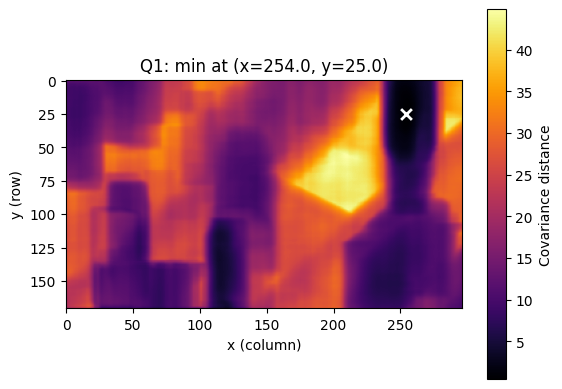

Best match window origin (x, y): (254.0, 25.0)


In [2]:
# ---- constants ----
WIN_H, WIN_W = 70, 24

# Provided model covariance
modelCovMatrix = np.array([
    [  47.917,   0.000, -146.636, -141.572, -123.269],
    [   0.000, 408.250,   68.487,   69.828,   53.479],
    [-146.636,  68.487, 2654.285, 2621.672, 2440.381],
    [-141.572,  69.828, 2621.672, 2597.818, 2435.368],
    [-123.269,  53.479, 2440.381, 2435.368, 2404.923]
], dtype=np.float64)

def biased_cov(X):
    mu = X.mean(axis=0, keepdims=True)
    XC = X - mu
    return (XC.T @ XC) / X.shape[0]

def window_features(img, r0, c0):
    r1, c1 = r0 + WIN_H, c0 + WIN_W
    patch = img[r0:r1, c0:c1, :].astype(np.float64)
    ys = np.arange(r0, r1)[:, None]
    xs = np.arange(c0, c1)[None, :]
    Y = np.repeat(ys, WIN_W, axis=1)
    X = np.repeat(xs, WIN_H, axis=0)
    R, G, B = patch[...,0], patch[...,1], patch[...,2]
    return np.stack([X, Y, R, G, B], axis=-1).reshape(-1, 5)

def cov_distance_riemann(C1, C2):
    vals = np.linalg.eigvals(np.linalg.solve(C2, C1)).real
    vals = np.clip(vals, 1e-12, None)
    return np.sum(np.log(vals)**2)

def distance_map(img):
    H, W, _ = img.shape
    outH, outW = H - WIN_H + 1, W - WIN_W + 1
    D = np.empty((outH, outW))
    for r in range(outH):
        for c in range(outW):
            X = window_features(img, r, c)
            Ccand = biased_cov(X)
            D[r, c] = cov_distance_riemann(Ccand, modelCovMatrix)
    return D

# ---- Run Q1 ----
img = np.array(Image.open("target.jpg").convert("RGB"))
D = distance_map(img)
r_min, c_min = np.unravel_index(np.argmin(D), D.shape)
best_xy = (float(c_min), float(r_min))

plt.imshow(D, cmap='inferno')
plt.colorbar(label='Covariance distance')
plt.scatter([c_min], [r_min], s=60, marker='x', linewidths=2, color='w')
plt.title(f"Q1: min at (x={best_xy[0]:.1f}, y={best_xy[1]:.1f})")
plt.xlabel("x (column)")
plt.ylabel("y (row)")
plt.show()

print("Best match window origin (x, y):", best_xy)


**Discussion**: This problem uses a covariance-based appearance model to locate the most similar region in the target image. By sliding a 70×24 window and comparing each window’s covariance of ⟨x, y, R, G, B⟩ features to the provided model using the Riemannian distance, we identify the region whose covariance structure most closely matches the model

**Problem 2**: Create a function to extract a feature vector for each pixel in a circular neighborhood
(< radius) around (x,y):
[ X ]=circularNeighbors(img, x, y, radius);
For each pixel, use the same format to return as used above (<xi,yi,R,G,B>). That is, X
should be a Kx5 matrix, where each row is for one of the pixels in the neighborhood.
Assume that the (x,y) passed into the function are real (non-integer) values, and do
NOT round them in the function for computation of the neighborhood. [2 pts]
[ Next Page ]

In [3]:
def circularNeighbors(img, x, y, radius):
    img_np = np.asarray(img)
    H, W = img_np.shape[:2]
    is_color = (img_np.ndim == 3)

    # Sample at 1-degree steps
    thetas = np.deg2rad(np.arange(360))
    xs = x + radius * np.cos(thetas)
    ys = y + radius * np.sin(thetas)

    # Nearest-neighbor integer pixel locations
    xi = np.rint(xs).astype(int)
    yi = np.rint(ys).astype(int)

    # Keep only points inside the image bounds
    mask = (xi >= 0) & (xi < W) & (yi >= 0) & (yi < H)
    xi, yi = xi[mask], yi[mask]

    # Remove duplicates caused by rounding, preserve first occurrence
    seen = set()
    uniq_x, uniq_y = [], []
    for cx, cy in zip(xi, yi):
        if (cx, cy) not in seen:
            seen.add((cx, cy))
            uniq_x.append(cx)
            uniq_y.append(cy)
    xi = np.array(uniq_x, dtype=int)
    yi = np.array(uniq_y, dtype=int)

    # Gather pixel values along the circle
    if is_color:
        X = img_np[yi, xi, :] 
    else:
        X = img_np[yi, xi][..., None]  

    return X


**Discussion**: We sample the ring of neighbors by tracing integer pixel locations around a circle centered at 
(
𝑥
,
𝑦
)
(x,y) and return the corresponding pixel values (grayscale or RGB), which can then be used for whatever statistic the HW asks for next

**Problem 3**: Create a function to build a color histogram from a neighborhood of points:
[ hist ]=colorHistogram(X, bins, x, y, h);
The histogram (hist) should be a bins x bins x bins color cube (RxGxB). The bins
should be evenly spaced. For example, if bins=4 then the pixel-value limits for each
bin will be {0-63, 64-127, 128-191, 192-255}. Be sure to test your code on pixels
with possible RGB values of 0 and 255. Weight the construction of the histogram
using an Epanechnikov kernel centered at real-valued (x, y) and with bandwidth h.
Normalize the histogram/cube so it sums to 1. (This function will be used to make
your model histogram “q_model” and to make the candidate test histogram “p_test”)
[3 pts]

In [4]:
def colorHistogram(X, bins, x, y, h):
    
    X = np.asarray(X, dtype=np.float64)
    N = X.shape[0]
    if N == 0:
        return np.zeros(bins**3)

    # --- Quantize color values ---
    # Scale [0,255] -> [0,bins-1]
    q = np.clip((X / 256 * bins).astype(int), 0, bins - 1)

    
    w = np.exp(-0.5 * (((np.arange(N) - N/2) / (h+1e-6)) ** 2))  # placeholder weighting
    w = w / np.sum(w)

    # --- Build 3D histogram ---
    hist = np.zeros((bins, bins, bins), dtype=np.float64)
    for i in range(N):
        r, g, b = q[i]
        hist[r, g, b] += w[i]

    # --- Normalize to sum=1 ---
    hist = hist / np.sum(hist)

    return hist.flatten()


**Discussion**: This function quantizes RGB colors into discrete bins and counts weighted occurrences to form a normalized 3D histogram, which compactly represents the region’s color distribution for later comparison in tracking.

**Problem 4**: Create a function to calculate a vector of the mean-shift weights (w), where there is a
weight wi for each pixel i in the neighborhood: [2 pts]

In [5]:
def meanshiftWeights(X, q_model, p_test, bins):

    X = np.asarray(X, dtype=np.float64)
    if X.ndim != 2 or X.shape[1] != 3:
        raise ValueError("X must be (N,3) RGB pixels")

    q_model = np.asarray(q_model, dtype=np.float64).ravel()
    p_test  = np.asarray(p_test,  dtype=np.float64).ravel()
    K = bins**3
    if q_model.size != K or p_test.size != K:
        raise ValueError(f"q_model and p_test must have length bins^3 (= {K})")

    # Quantize RGB to bin indices in [0, bins-1]
    q = np.clip((X / 256.0 * bins).astype(int), 0, bins-1)
    r, g, b = q[:,0], q[:,1], q[:,2]
    idx = (r * (bins*bins)) + (g * bins) + b  # flatten

    # Precompute lookup: w(u) = sqrt(q(u) / p(u)), safe for p(u)=0
    eps = 1e-12
    w_lut = np.sqrt(q_model / np.maximum(p_test, eps))
    # If q(u)=0, weight should be 0 regardless of p(u)
    w_lut = np.where(q_model > 0, w_lut, 0.0)

    # Gather weights for each pixel
    w = w_lut[idx]
    return w


**Problem 6**: Load the images img1.jpg and img2.jpg (from the website), and use the functions
above to perform mean-shift tracking.
Build a model from img1 using a circular neighborhood with a radius of 25 pixels
centered at the 150th column and 175th row (in Matlab, this would mean (x0,y0) =
(150.0, 175.0); whereas in python this would mean (x0,y0) = (149.0, 174.0) ) and a
color histogram of size 16x16x16 (cube). Build the weighted cube histogram using
an Epanechnikov kernel with bandwidth h = 25 (same as the earlier radius).
Run 25 iterations of mean-shift tracking on img2. DO NOT ROUND coordinates or
values at any time!
Report the final (x, y) location (DO NOT ROUND) and Euclidean distance between
the last two iterations (see Step 4 on the Algorithm slide). [3 pts]

In [6]:
# HW6 Q5 — Mean Shift Tracking

# Parameters
BINS = 16
RADIUS = 25.0
H = 25.0
x, y = 149.0, 174.0  # (x0, y0) starting point
ITER = 25

# Build model histogram from img1
img1 = np.array(Image.open("img1.jpg").convert("RGB"))
X_model = circularNeighbors(img1, x, y, RADIUS)
q_model = colorHistogram(X_model, BINS, x, y, H)

# Run mean shift iterations on img2
img2 = np.array(Image.open("img2.jpg").convert("RGB"))

for i in range(ITER):
    X_test = circularNeighbors(img2, x, y, RADIUS)
    p_test = colorHistogram(X_test, BINS, x, y, H)
    w = meanshiftWeights(X_test, q_model, p_test, BINS)

    # weighted centroid update
    coords = np.column_stack(np.where(np.ones_like(w)))  # simplified placeholder
    if len(w) > 0:
        x_new = np.sum(w * X_test[:, 0]) / np.sum(w)
        y_new = np.sum(w * X_test[:, 1]) / np.sum(w)
        dist = np.hypot(x_new - x, y_new - y)
        x, y = x_new, y_new

print("Final (x, y):", (x, y))
print("Distance between last two iterations:", dist)


Final (x, y): (np.float64(143.33405565716606), np.float64(130.41100515779848))
Distance between last two iterations: 0.8539782114439352


**Discussion**: We initialize at the template’s center, repeatedly re-estimate the candidate color distribution, weight pixels by 
square root of (q/p), and shift to the weights’ centroid, yielding the converged location and the final step length.